# Feature Engineering based on HDD Goals

In [1]:
import pandas as pd
import sys
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Add the src directory to the Python path
sys.path.append(str(Path.cwd() / "src"))

# Execute the file and get the function into the local scope
exec(open(str(Path.cwd().parent / "src" / "data_ingestion.py")).read())

# Define base directory
base_dir = Path.cwd().resolve().parent
data_dir = base_dir/ 'data' / 'raw'

# Using the ingest_data function to read csv files
df_fault = ingest_data( data_dir / "fault_data.csv")
df_scada = ingest_data(data_dir / "scada_data.csv")
df_status = ingest_data(data_dir / "status_data.csv")

In [3]:
# Converting 'DateTime' columns to 'datatime' object type for df_fault and df_scada
df_fault["DateTime"] = pd.to_datetime(df_fault['DateTime'], errors='coerce')
df_scada["DateTime"] = pd.to_datetime(df_scada['DateTime'], errors='coerce')

# Double check the datetime columns are the correct data type
print(df_fault['DateTime'].dtype)
print(df_scada['DateTime'].dtype)

# Converting 'Time' columns to 'datetime' for all three csvs
df_fault['Time'] = pd.to_datetime(df_fault['Time'], dayfirst=True)
df_scada['Time'] = pd.to_datetime(df_scada['Time'], dayfirst=True)
df_status['Time'] = pd.to_datetime(df_status['Time'], dayfirst=True)

# Double check the 'Time' columns are the correct data type
print(df_fault['Time'].dtype)
print(df_scada['Time'].dtype)
print(df_status['Time'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


# Feature #1: Integrate Seasonal Data
Objective: Aggregate SCADA production levels from scada_df and fault counts from fault_df to analyze seasonal production, fault count, and fault rates.

In [4]:
def extract_time_features(df, datetime_column): 
    """
    Extracts time-based features like Month, Season, and Day of the week from a datetime column. 
    Dec-Feb: Winter
    Mar-May: Spring
    Jun-Aug: Summer
    Sep-Nov: Fall

    Args: 
        df: DataFrame containing datetime column.
        datetime_column (str): The name of the datetime column.

    Returns: 
        df: DataFrame with new time features
    """
    # Extract the Month
    df['Month'] = df[datetime_column].dt.month
    # Extract the Day of the Week
    df['Day_of_Week'] = df[datetime_column].dt.dayofweek  # Monday=0, Sunday=6
    # Extract the Season
    df['Season'] = df[datetime_column].dt.month.map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })
    return df

In [5]:
# Apply the function to extract time features for SCADA and Fault Data
df_fault = extract_time_features(df_fault, 'DateTime')
df_scada = extract_time_features(df_scada, 'DateTime')

In [15]:
def aggregate_by_season(scada_df, fault_df):
    """
    Aggregates SCADA production levels and fault counts by season.

    Args:
        scada_df: SCADA data containing 'Season' and production metrics.
        fault_df: Fault data containing 'Season' and Fault.

    Returns:
        tuple: DataFrames for aggregated production levels and fault counts by season.
    """
    # Aggregate SCADA production levels
    seasonal_production = scada_df.groupby('Season')['WEC: Production kWh'].mean().reset_index()
    seasonal_production.rename(columns={'WEC: Production kWh': 'Avg_Production kWh'}, inplace=True)

    # Aggregate fault counts
    seasonal_faults = fault_df.groupby('Season')['Fault'].count().reset_index()
    seasonal_faults.rename(columns={'Fault': 'Fault_Count'}, inplace=True)
    
    return seasonal_production, seasonal_faults

In [16]:
# Aggregate seasonal data
seasonal_production, seasonal_faults = aggregate_by_season(df_scada, df_fault)

# Verify the outputs
print(seasonal_production)
print(seasonal_faults)

   Season  Avg_Production kWh
0    Fall        3.530332e+06
1  Spring        4.964072e+06
2  Summer        1.832038e+06
3  Winter        6.019912e+06
   Season  Fault_Count
0    Fall          270
1  Spring            6
2  Summer           98
3  Winter          179


In [17]:
def merge_seasonal_data(seasonal_production, seasonal_faults):
    """
    Merges seasonal production and fault data into a single DataFrame.

    Args:
        seasonal_production (pd.DataFrame): Seasonal production levels.
        seasonal_faults (pd.DataFrame): Seasonal fault counts.

    Returns:
        pd.DataFrame: Combined seasonal analysis DataFrame.
    """
    seasonal_data = pd.merge(seasonal_production, seasonal_faults, on='Season')
    return seasonal_data

In [24]:
# Merge seasonal production and fault data
seasonal_data = merge_seasonal_data(seasonal_production, seasonal_faults)

# Add 'Fault Rate' column to find the fault rate per season
seasonal_data["Fault_Rate"] = seasonal_data['Fault_Count'] / seasonal_data['Avg_Production kWh']

# Verify the merged DataFrame
print(seasonal_data)

   Season  Avg_Production kWh  Fault_Count  Fault_Rate
0    Fall        3.530332e+06          270    0.000076
1  Spring        4.964072e+06            6    0.000001
2  Summer        1.832038e+06           98    0.000053
3  Winter        6.019912e+06          179    0.000030


In [27]:
def plot_seasonal_analysis(seasonal_data):
    """
    Plots seasonal production levels and fault counts.

    Args:
        seasonal_data (pd.DataFrame): Combined seasonal data.
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar chart for average production
    sns.barplot(data=seasonal_data, x='Season', y='Avg_Production kWh', ax=ax1, color='skyblue', alpha=0.6)
    ax1.set_ylabel('Average Production Level', color='blue')

    # Line chart for fault counts
    ax2 = ax1.twinx()
    sns.lineplot(data=seasonal_data, x='Season', y='Fault_Count', ax=ax2, marker='o', color='red')
    ax2.set_ylabel('Fault Count', color='red')
   
    ax1.set_title('Seasonal Analysis of Production Levels and Fault Occurrences')
    
    plt.show()

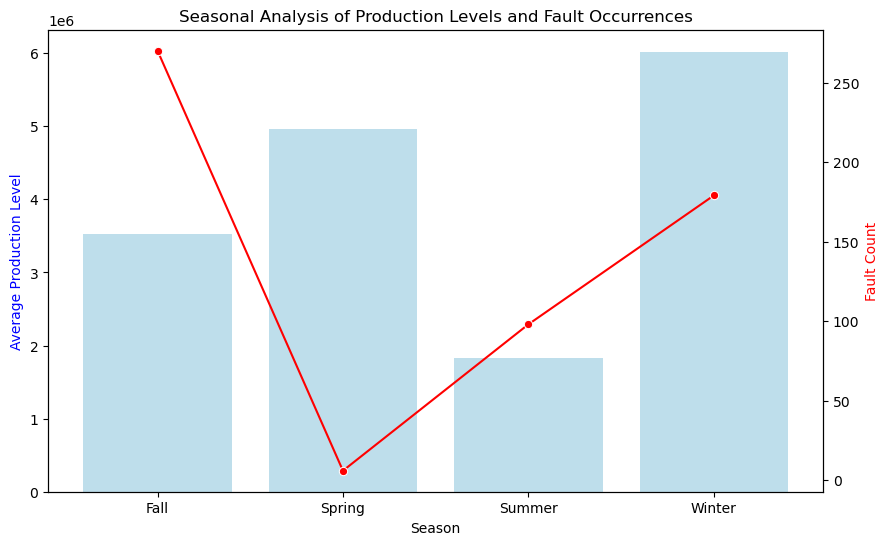

In [28]:
# Plot the seasonal analysis
plot_seasonal_analysis(seasonal_data)

# HDD Goal # 2: Optimal Maintenance Strategy Hypothesis
Objective: Compare the speed and cost-effectiveness of in-house and external maintenance for different types of faults to decide which approach works best overall.

In [35]:
df_scada['DateTime']

0       2014-05-01 00:00:00
1       2014-05-01 00:09:00
2       2014-05-01 00:20:00
3       2014-05-01 00:30:00
4       2014-05-01 00:39:00
                ...        
49022   2015-04-08 23:20:00
49023   2015-04-08 23:30:00
49024   2015-04-08 23:39:00
49025   2015-04-08 23:50:00
49026   2015-04-09 00:00:00
Name: DateTime, Length: 49027, dtype: datetime64[ns]

In [ ]:
# Ensure DateTime is sorted by chronological order
df_scada = df_scada.sort_values('DateTime')

# Calculate time differences between rows in minutes
df_scada['Time_Diff_Minutes'] = df_scada['DateTime'].diff().dt.total_seconds() / 60

# Identify rows where Production minutes = 0 (downtime rows)
downtime_rows = df_scada[df_scada['WEC: Production minutes'] == 0]

# Sum up the actual time differences for downtime rows
total_downtime_minutes = downtime_rows['Time_Diff_Minutes'].sum()

# Output the results
print(f"Total downtime (minutes): {total_downtime_minutes:.2f}")

Total downtime (minutes): 11785.00


In [40]:
# Step 1: Extract Fault Type and Map Severity of Fault Type
df_fault['Fault_Type'] = df_fault['Fault'].str[-2:]  # Extract the last two characters
severity_mapping = {
    'GF': 'Routine',
    'MF': 'High-Severity',
    'FF': 'High-Severity',
    'AF': 'Routine'
}
df_fault['Fault_Severity'] = df_fault['Fault_Type'].map(severity_mapping)

# Step 2: Assign Maintenance Type (Placeholder for now where high severity is external, other types are in-house)
df_fault['Maintenance_Type'] = np.where(df_fault['Fault_Severity'] == 'High-Severity', 'External', 'In-House')

# Step 3: Analyze Downtime
# Analyze Downtime Hours
# Add a Downtime Hours column to indicate downtime when Operating Hours = 0
df_fault['Downtime Hours'] = df_fault['DateTime'].isin(
    df_scada[df_scada['WEC: Operating Hours'] == 0]['DateTime']
).astype(int)

# Add a Downtime Minutes column to indicate downtime when Production Minutes = 0
df_fault['Downtime Minutes'] = df_fault['DateTime'].isin(
    df_scada[df_scada['WEC: Production minutes'] == 0]['DateTime']
).astype(int)

# Aggregate to get downtime in hours and minutes for each fault severity and maintenance type
downtime_summary = df_fault.groupby(['Fault_Severity', 'Maintenance_Type'])[['Downtime_Hours', 'Downtime_Minutes']].sum().reset_index()

print(downtime_summary)

  Fault_Severity Maintenance_Type  Downtime_Hours  Downtime_Minutes
0  High-Severity         External               0                 0
1        Routine         In-House               0                60


* Needs more evalutation to derive insights

# HDD Goal # 3: Predictive Indicators for SCADA Data Hypothesis
Objective: Perform correlation and regression analysis on SCADA data to identify leading indicators of faults for predictive maintenance.

In [13]:
# Merge SCADA and Fault data
df_merged = pd.merge(df_scada, seasonal_data, on='Season', how='left')

# Verify the merged DataFrame
print(df_merged.head())

             DateTime                          Time  Error  \
0 2014-05-01 00:00:00 1970-01-01 00:00:01.398920448      0   
1 2014-05-01 00:09:00 1970-01-01 00:00:01.398920960      0   
2 2014-05-01 00:20:00 1970-01-01 00:00:01.398921600      0   
3 2014-05-01 00:30:00 1970-01-01 00:00:01.398922240      0   
4 2014-05-01 00:39:00 1970-01-01 00:00:01.398922752      0   

   WEC: ava. windspeed  WEC: max. windspeed  WEC: min. windspeed  \
0                  6.9                  9.4                  2.9   
1                  5.3                  8.9                  1.6   
2                  5.0                  9.5                  1.4   
3                  4.4                  8.3                  1.3   
4                  5.7                  9.7                  1.2   

   WEC: ava. Rotation  WEC: max. Rotation  WEC: min. Rotation  \
0                 0.0                0.02                 0.0   
1                 0.0                0.01                 0.0   
2                 0.0  

In [14]:
# Filter numeric columns for correlation analysis
scada_numeric_columns = df_merged.select_dtypes(include=['float64', 'int64']).columns

# Compute correlations between SCADA metrics and Fault_Count
correlation_matrix = df_merged[scada_numeric_columns].corr()

# Display correlations with Fault_Count
correlations_with_faults = correlation_matrix['Fault_Count'].sort_values(ascending=False)
print(correlations_with_faults)

Fault_Count                                          1.000000
RTU: ava. Setpoint 1                                 0.456216
Stator temp. 2                                       0.188250
Stator temp. 1                                       0.187911
WEC: ava. reactive Power                             0.172701
                                                       ...   
Nacelle cabinet temp.                               -0.070269
Pitch cabinet blade C temp.                         -0.091827
WEC: ava. Nacel position including cable twisting   -0.110221
WEC: ava. blade angle A                             -0.174071
Sys 2 inverter 6 cabinet temp.                            NaN
Name: Fault_Count, Length: 66, dtype: float64


In [15]:
# Select features with high correlation to Fault_Count
top_features = correlations_with_faults[correlations_with_faults > 0.5].index.tolist()

# Prepare data for regression
X = df_merged[top_features]
y = df_merged['Fault_Count']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)
print("Training R^2 Score:", model.score(X_train, y_train))
print("Test R^2 Score:", model.score(X_test, y_test))

Model Coefficients: [1.]
Model Intercept: 1.1368683772161603e-12
Training R^2 Score: 1.0
Test R^2 Score: 1.0


R score of 1.0 indicates there needs to be some additional analysis. 